In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

%matplotlib inline

Graph info (single mode): Name: G
Type: Graph
Number of nodes: 6
Number of edges: 7
Average degree:   2.3333

Graph nodes: [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]



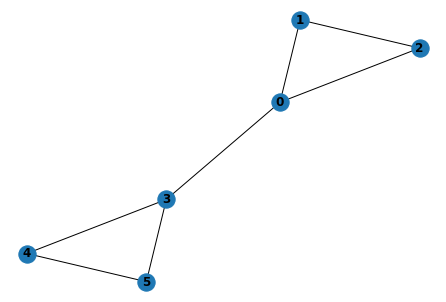

In [2]:
G = nx.Graph(name='G')
[ G.add_node(idx, name=idx) for idx in range(6) ]

edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]

G.add_edges_from(edges)

print(f'Graph info (single mode): {nx.info(G)}\n')

print(f'Graph nodes: {G.nodes.data()}\n')

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [40]:
# We need to generate an Adjacency matrix (edges connections info) and features matrix (N x F) where N is the number of nodes and F is the number of features per node.
# A: N x N
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
# We need to include self-loops in the graph to include the feature of any given node i in the adjacency matrix
np.fill_diagonal(A, 1)

same_node_edges = [ (idx, idx) for idx in range(G.number_of_nodes()) ]
G.add_edges_from(same_node_edges)
print(f'A size: {A.shape}\n')

# X: N x F
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X, axis=1)
print(f'X size: {X.shape}')

A size: (6, 6)

X size: (6, 1)


In [41]:
print(f'A: \n{A}\n')
print(f'X: {X}\n')
AX = A.dot(X)

print(f'AX: {AX.T}\n')

A: 
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]

X: [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]

AX: [[ 6.  3.  3. 12. 12. 12.]]



In [45]:
# normalize AX by using the Degree Matrix, D -> AX_norm = D.invAX where degree is the number of edges any given node is connected to
# D: N x N
N = G.number_of_nodes()
F = 1
nedges_per_node = G.degree()
print(nedges_per_node)
D = np.diag([ pair[1] for pair in nedges_per_node ])
print(D)
D_inv = np.linalg.inv(D)
print(D_inv)
DAX = D_inv.dot(AX)
print(DAX)

[(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
[[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
[[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
[[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


In [46]:
# A better normalization would be by symmetric normalization
D_inv_sqrt = fractional_matrix_power(D, -.5)
DADX = D_inv_sqrt.dot(A.dot(D_inv_sqrt.dot(X)))
print(DADX)

[[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


In [61]:
# 2 layers Graph Convolution Network
# H_t+1 = activation(W_t.H_t.A) or H' = a(W.H.A* + b)
np.random.seed(77777)
nhidden = 4
noutput = 2
W0 = np.random.random((X.shape[1], nhidden)) * 0.01
b0 = np.random.random(1)

W1 = np.random.random((nhidden, noutput)) * 0.01
b1 = np.random.random(1)

def GCN(W, H, A):
    I = np.identity(A.shape[0])
    A_hat = A + I # extract diagonal values
    D = np.diag(np.sum(A_hat, axis=0))
    D_inv_sqrt = fractional_matrix_power(D, -0.5)
    DADX = D_inv_sqrt.dot(A_hat).dot(D_inv_sqrt).dot(H).dot(W)
    return np.maximum(0, DADX)

H1 = GCN(W0, X, A)
H2 = GCN(W1, H1, A)

print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00024625 0.00016864]
 [0.00016328 0.00011182]
 [0.00017258 0.00011819]
 [0.00049854 0.00034142]
 [0.00055407 0.00037944]
 [0.00056338 0.00038582]]


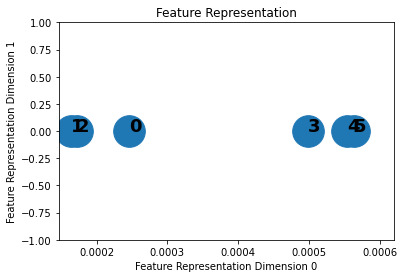

In [62]:
def plot_features(H2):
    #Plot the features representation
    x = H2[: , 0]
    y = H2[: , 1]

    size = 1000

    plt.scatter(x, y, size)
    plt.xlim([np.min(x) * 0.9, np.max(x) * 1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()


plot_features(H2)